In [27]:
import numpy as np
import pandas as pd

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [40]:
with open('features.pickle', 'rb') as f:
    features = pickle.load(f)

In [181]:
df = pd.DataFrame.from_dict(features, orient='index')

In [182]:
df

,citation_density,year_difference,citing_location,citation_frequency,other_citations,self_reference,word,model,system,feature,...,input,described,large,well,value,processing,machine,linguistics,context,class
P05-3005-T1,0,3.0,0.110616,1,1,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,Uses
P05-3005-T2,0,2.0,0.110616,1,2,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,Uses
P05-3005-T3,0,5.0,0.169938,1,4,False,False,False,True,False,...,False,False,False,True,False,False,True,False,False,Uses
P05-3005-T4,0,4.0,0.169938,1,3,False,False,False,True,False,...,False,False,False,True,False,False,True,False,False,Background
P05-3005-T5,0,NaN,0.169938,1,4,False,False,False,True,False,...,False,False,False,True,False,False,True,False,False,Uses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D09-1056-T21,7,1.0,0.271579,1,1,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,Uses
D09-1056-T22,1,1.0,0.415088,1,3,False,False,True,True,True,...,False,False,False,False,False,False,True,False,False,Background
D09-1056-T23,2,5.0,0.052456,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Uses
D09-1056-T24,9,2.0,0.218772,1,2,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,Background


In [183]:
clean_df = df[(df['class'] != 'Unknown') & (df['class'] != 'Reference') & (df['class'] != 'Prior')]

In [184]:
clean_df['class'].value_counts()

Background              802
Uses                    310
Compares & Contrasts    286
Motivation               84
Future                   63
Extends                  21
Name: class, dtype: int64

In [185]:
stacked = clean_df[['class']].stack()
clean_df[['class']] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack()

/home/dmitry/ml/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [186]:
clean_df = clean_df.fillna(df.mean())

In [187]:
clean_df.describe()

,citation_density,year_difference,citing_location,citation_frequency,other_citations,class
count,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000
mean,3.363985,6.040420,0.377990,2.078544,4.160920,1.293103
std,3.418473,6.323509,0.271195,1.555643,4.032412,1.128902
min,0.000000,0.000000,0.009445,1.000000,0.000000,0.000000
25%,1.000000,2.000000,0.133419,1.000000,2.000000,1.000000
50%,2.000000,4.000000,0.307391,1.000000,3.000000,1.000000
75%,5.000000,8.000000,0.603016,3.000000,5.000000,2.000000
max,19.000000,56.000000,0.939097,10.000000,41.000000,5.000000


In [188]:
clean_df.shape

(1566, 107)

In [189]:
indexes_of_categories = list(clean_df.columns)[5:-1]

In [190]:
X, y = clean_df.iloc[:, :-1], clean_df.iloc[:, -1] 

In [256]:
def plot_importance(importances):
    indices = np.flipud(np.argsort(importances)[::-1][:10])
    feature_names = list(clean_df.columns)[:-1]
    
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.show()

#### Random forest

In [214]:
param_grid_rf = {
    'n_estimators': [20, 40, 60, 100, 120],
    'max_depth': [10, 15, 20, 100]
    }

In [215]:
def get_best_rf(metric, param_grid):
    best_score = 0
    best_params = None
    best_model = None
    
    for n in param_grid['n_estimators']:
        for max_d in param_grid['max_depth']:
            params = {
                'n_estimators' : n,
                'max_depth' : max_d
            }
            clf = RandomForestClassifier(**params)
            cur_score = np.mean(cross_val_score(clf, X, y, scoring=metric, cv=5))
            if cur_score > best_score:
                best_score = cur_score
                best_params = params
                best_model = clf
    return best_score, best_params, best_model

In [216]:
rf_macro_score, rf_macro_params, rf_macro_clf = get_best_rf('f1_macro', param_grid_rf)

In [219]:
rf_macro_score, rf_macro_params

(0.14746474250250566, {'n_estimators': 20, 'max_depth': 20})

In [218]:
rf_micro_score, rf_micro_params, rf_micro_clf = get_best_rf('f1_micro', param_grid_rf)

In [220]:
rf_micro_score, rf_micro_params

(0.501288130074683, {'n_estimators': 120, 'max_depth': 10})

In [243]:
rf_micro_clf.fit(X, y)

RandomForestClassifier(max_depth=10, n_estimators=120)

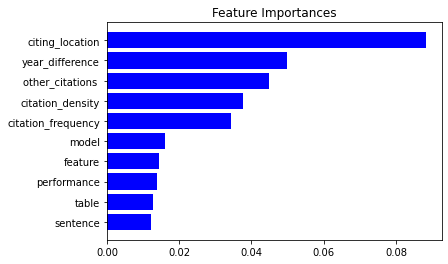

In [257]:
plot_importance(rf_micro_clf.feature_importances_)

#### LightGBM

In [222]:
param_grid_lgb = {
    'n_estimators': [20, 40, 60, 100, 140],
    'max_depth': [10, 15, 20, 120],
    'num_leaves': [6, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
    }

In [224]:
def get_best_lgb(metric, param_grid):
    best_score = 0
    best_params = None
    best_model = None
    
    for n in param_grid['n_estimators']:
        for max_d in param_grid['max_depth']:
            for num_l in param_grid['num_leaves']:
                for lr in param_grid['learning_rate']:
                    params = {
                        'n_estimators' : n,
                        'max_depth' : max_d,
                        'num_leaves' : num_l,
                        'learning_rate' : lr, 
                    }
                    clf = lgb.LGBMClassifier(**params)
                    cur_score = np.mean(cross_val_score(clf, X, y, scoring=metric, cv=5))
                    if cur_score > best_score:
                        best_score = cur_score
                        best_params = params
                        best_model = clf
    return best_score, best_params, best_model

In [225]:
lgb_macro_score, lgb_macro_params, lgb_macro_clf = get_best_lgb('f1_macro', param_grid)

In [226]:
lgb_macro_score, lgb_macro_params

(0.20292716715379028,
 {'n_estimators': 20, 'max_depth': 10, 'num_leaves': 6, 'learning_rate': 1.0})

In [227]:
lgb_micro_score, lgb_micro_params, lgb_micro_clf = get_best_lgb('f1_micro', param_grid)

In [228]:
lgb_micro_score, lgb_micro_params

(0.5140473331841029,
 {'n_estimators': 60,
  'max_depth': 15,
  'num_leaves': 30,
  'learning_rate': 0.01})

In [258]:
lgb_micro_clf.fit(X, y)

LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=60, num_leaves=30)

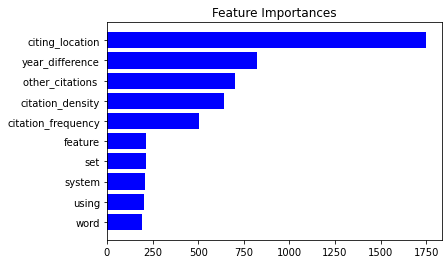

In [259]:
plot_importance(lgb_micro_clf.feature_importances_)

#### Log reg

In [237]:
reg_clf = LogisticRegression(solver='lbfgs', max_iter=1000)

In [239]:
np.mean(cross_val_score(reg_clf, X, y, scoring='f1_macro', cv=5))

0.1977675017053236

In [240]:
np.mean(cross_val_score(reg_clf, X, y, scoring='f1_micro', cv=5))

0.4349056795751003